# 0. Importing the Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, re, json, time
import itertools, collections
from importlib import reload
from IPython.display import display
import scipy.sparse
import nltk
from w266_common import utils, vocabulary, tf_embed_viz

/home/luisarmandovillarreal/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. Getting Data

In [2]:
df = pd.read_csv('data/clean_tweets.csv')

In [3]:
# getting the timestamp column in proper format
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)

In [4]:
# extracting date from timestamp
df['date'] = df['timestamp'].map(lambda x:x.date())

We only want data from 4th March, 2019 onwards. This is the period we have chosen to explore.

In [5]:
df = df[df['date'] >= pd.to_datetime('2019-03-04').date()]

In [6]:
df.head()

,tweet_id,ticker,timestamp,tweet,date
0,110526365952428032,DWDP,2019-03-12 00:26:00,<s> traders sell shares of on strength </s>,2019-03-12
1,1103805919568293888,T,2019-03-07 23:53:00,<s> ich ich </s>,2019-03-07
2,1103801007375552514,T,2019-03-07 23:34:00,<s> house democrats seek details of trump eff...,2019-03-07
3,1103735736153432064,T,2019-03-07 19:14:00,<s> t two new revenue streams att inves...,2019-03-07
4,1103724496027115520,T,2019-03-07 18:30:00,<s> telus co declares quarterly dividend of t...,2019-03-07


In [7]:
df.shape

(2572925, 5)

In [8]:
# removing all the duplicate tweets
df.drop_duplicates(inplace=True)

In [9]:
df.shape

(2572925, 5)

# 2. Adding Sentiment Score to Each Tweet

For the sentiment score for our tweets, we decided to use 'vaderSentimentAnalyzer'. As per the definition from the creators:

**VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.**

Since we are exclusively dealing with sentimenn analysis of social media messages (tweets, in our case), VADER seemed the appropriate choice. 

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [11]:
# extracting sentiment score for each tweet
# we are interested in only the compound polarity score
# details about this number can be found in paper accompanying this notebook

analyzer = SentimentIntensityAnalyzer()
df['compound'] = df['tweet'].map(
    lambda x: list(analyzer.polarity_scores(x).values())[3])

In [12]:
# # extracting day_name, day, and day_of_week in case we need it for analysis
# combined_df['day_name'] = combined_df['timestamp'].map(lambda x: x.day_name())
# combined_df['day'] = combined_df['timestamp'].map(lambda x: x.day)
# combined_df['day_of_week'] = combined_df['timestamp'].map(lambda x: x.dayofweek)

In [13]:
#combined_df.to_csv('tweets_with_sentiment.csv')
#combined_df = pd.read_csv('tweets_with_sentiment.csv', index_col=False)

In [14]:
df.head()

,tweet_id,ticker,timestamp,tweet,date,compound
0,110526365952428032,DWDP,2019-03-12 00:26:00,<s> traders sell shares of on strength </s>,2019-03-12,0.6597
1,1103805919568293888,T,2019-03-07 23:53:00,<s> ich ich </s>,2019-03-07,0.0000
2,1103801007375552514,T,2019-03-07 23:34:00,<s> house democrats seek details of trump eff...,2019-03-07,-0.4404
3,1103735736153432064,T,2019-03-07 19:14:00,<s> t two new revenue streams att inves...,2019-03-07,0.0000
4,1103724496027115520,T,2019-03-07 18:30:00,<s> telus co declares quarterly dividend of t...,2019-03-07,0.0000


In [15]:
df.shape

(2572925, 6)

In [16]:
df.sort_values(by = 'compound', ascending=False, inplace=True)

In [17]:
df.head()

,tweet_id,ticker,timestamp,tweet,date,compound
2340363,1111066228028772353,MCD,2019-03-28 00:43:00,<s> seth rich seth rich seth rich seth rich se...,2019-03-28,0.9972
629831,1108837319778406406,MSFT,2019-03-21 21:06:00,<s> pagar entre 100 y 180 euros al ao por un s...,2019-03-21,0.9944
1591748,1109126400894816258,V,2019-03-22 16:15:00,<s> charlize sky love i love you my life sky i...,2019-03-22,0.9923
1591698,1109127331610853379,V,2019-03-22 16:18:00,<s> charlize sky love i love you my life sky i...,2019-03-22,0.9923
315952,1110920183894421505,INTC,2019-03-27 15:03:00,<s> apex legends is in apex and they have to b...,2019-03-27,0.9920


In [19]:
df_daily = df.groupby(['ticker','date'])['compound'].mean()

In [30]:
df_daily = df_daily.reset_index()

In [35]:
df_daily.to_csv('data_daily.csv', sep=',', index=False)

In [18]:
df['compound'].value_counts()

 0.0000    1269465
-0.2960      77956
 0.3612      33173
 0.4404      31864
 0.4215      29763
 0.3400      28078
 0.4019      27674
 0.3182      23210
-0.4019      22571
 0.6369      20544
 0.2023      20318
 0.4588      19773
-0.5267      18216
 0.1779      17221
 0.0772      16810
-0.5574      16742
 0.3818      16457
 0.2960      16136
 0.2732      15710
 0.4939      15662
 0.5106      15468
 0.5859      15047
 0.2500      13687
-0.3400      13687
 0.5719      13068
-0.2263      12611
 0.4767      11983
-0.4767      11950
 0.6249      11736
-0.1027      11613
            ...   
-0.4886          1
-0.1353          1
-0.4187          1
-0.1211          1
 0.7068          1
-0.7974          1
 0.6489          1
-0.0225          1
-0.2241          1
-0.2378          1
-0.8287          1
-0.2839          1
 0.2549          1
 0.1958          1
 0.1812          1
-0.0774          1
-0.5363          1
-0.3060          1
 0.0070          1
-0.1792          1
 0.2417          1
-0.1251     

## 2.1 Sample Tweets to Manually Ascertain Polarity Score Quality

This portion is aimed at looking at few samples of tweets and manually see if the polarity scores sit well with the content of the tweet.
We will look at all three cases: positive, neutral and negative example tweets.

#### 2.1.1 Positive Tweets

In [23]:
df_temp = df.loc[df['compound'] > 0.05]
for row in df_temp[:10].itertuples():
    print(row[2])
    print(row[4])
    print('\n')

MCD
<s> seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich seth rich </s>


MSFT
<s> pagar entre 100 y 180 euros al ao por un servicio de que de ser y encima va como la xd xd xd xd xd xd xd xd xd xd xd xd xd </s>


V
<s> charlize sky love i love you my life sky i do not stop you from thinking love please my life i ask you with love heaven help me with the visa to be able to see the united states i love you i want to be with you love heaven please my name is jose luis noboa giler  </s>


V
<s> charlize sky love i love you my life sky i do not stop you from thinking love please my life i ask you with love heaven help me with the visa to be able to see the united states i love you i want to be with you love heaven please my name is jose luis noboa giler sky  </s>


INTC
<s> apex legends is in apex and they have to be at least one for a while but i wann

#### 2.1.2 Negative Tweets

In [24]:
df_temp = df.loc[df['compound'] < -0.05]
for row in df_temp[-10:].itertuples():
    print(row[2])
    print(row[4])
    print('\n')

VZ
<s> fraud oriented 8 months verizon acknowledged that i owe have the but they continue to send and have reported their false claims to all three credit reporting fraud fraud fraud fraud fraud fraud fraud </s>


NFLX
<s> on my block on my block on my block on my block on my block on my block on my block on my block on my block on my block on my block on my block on my block on my block on my block on my block </s>


NFLX
<s> kung fu on netflix kung fu on netflix kung fu on netflix kung fu on netflix kung fu on netflix kung fu on netflix kung fu on netflix kung fu on netflix kung fu on netflix      </s>


T
<s> you same ass toxic jealous dumb worthless bitches i give a fuck about you at all how long you been how many male witnesses to that can speak on you a dead bitch tired of your shit bitch you a dead bitch </s>


NFLX
<s> fuck fuck netflix fuck netflix fuck netflix fuck netflix fuck netflix fuck netflix fuck netflix fuck netflix fuck fuck netflix and its dumb ass shows that litera

#### 2.1.3 Neutral Tweets

In [26]:
df_temp = df.loc[(df['compound'] < 0.05) & (df['compound'] > -0.05)]
for row in df_temp[:10].itertuples():
    print(row[2])
    print(row[4])
    print('\n')

BA
<s> i fully agree with at the the plane is not safe to fly canada just grounded the but i know that in the when the fix is put out for the system bug that may be causing these i will fly on the that the predecessor to </s>


INTC
<s> must be waiting for intel on what to be offended my timeline is soooo much more mature and all the liberal tears have </s>


LLY
<s> the drugmaker eli lilly will begin selling a cheaper version of its most popular in an effort to head off criticism about the rising costs of prescription read more   jdrf  </s>


ORCL
<s> the british house of commons parliamentary sessions are more engaging drama than any soap ever what an utter ludicrous situation has </s>


BA
<s> that is the reason of people are now looking hard at that particular approving the as the same type was financially very advantageous to of as they can advertise no pilot type ratings are </s>


V
<s> unlike germans pay visa fees in most i want the passport </s>


DIS
<s> lion king has the bet

## 2.2 Data Exploration with Aggregate Sentiment

In [27]:
# get counts of positive, neutral and negative tweets
def count_sentiments(sentiment):

    if sentiment >= 0.05:
        return 1
    elif (sentiment > -0.05) and (sentiment < 0.05):
        return 0
    else:
        return -1

In [29]:
# new column to determine if tweet is positive or negative
df['pos/neg'] = df['compound'].map(count_sentiments)

In [30]:
# new dataframe to count individual sentiment tweets per day
sentiment_counts = pd.DataFrame(df.groupby(['date', 'pos/neg'])['tweet'].agg('count'))

In [32]:
sentiment_counts.head()

,,tweet
date,pos/neg,
2016-12-29,0,1
2017-06-04,0,1
2017-07-28,0,1
2017-08-21,1,1
2017-12-14,0,1


In [37]:
# groupby dates to get counts of tweets by day
sent_agg_by_day = pd.DataFrame(df.groupby('date')['compound'].agg('count'))

In [38]:
sent_agg_by_day

,compound
date,
2019-03-04,25948
2019-03-05,30296
2019-03-06,32652
2019-03-07,31029
2019-03-08,26455
2019-03-09,18026
2019-03-10,16637
2019-03-11,28330
2019-03-12,36180


In [32]:
# merging datasets to get counts of positive, negative and neutral tweets daily
merged_dataset = sentiment_counts.merge(sent_agg_by_day, left_index=True, right_index=True)

In [33]:
merged_dataset = merged_dataset.reset_index()

In [34]:
merged_dataset.head()

,date,pos/neg,tweet,compound
0,2019-03-04,-1,5970,34697
1,2019-03-04,0,14727,34697
2,2019-03-04,1,14000,34697
3,2019-03-05,-1,6811,38736
4,2019-03-05,0,16115,38736


In [35]:
#merged_dataset = merged_dataset.unstack()
merged_dataset = merged_dataset.pivot_table(index='date', values='tweet', columns='pos/neg')

In [36]:
merged_dataset.rename(columns={-1: 'neg', 0:'neutral', 1:'pos'}, inplace=True)

In [37]:
merged_dataset['abs_sentiment'] = merged_dataset['pos']-merged_dataset['neg']
merged_dataset['rel_sentiment'] = (merged_dataset['pos']-merged_dataset['neg'])/(merged_dataset['pos']+merged_dataset['neg'])

The relative and absolute sentiment are calculated using the aggregate number of positive and negative tweets. 

In [38]:
merged_dataset.head()

pos/neg,neg,neutral,pos,abs_sentiment,rel_sentiment
date,,,,,
2019-03-04,5970,14727,14000,8030,0.402103
2019-03-05,6811,16115,15810,8999,0.397816
2019-03-06,7452,17841,17015,9563,0.390853
2019-03-07,6847,16893,16929,10082,0.424041
2019-03-08,5759,15008,15602,9843,0.460793


In [39]:
avg_sent_by_day = combined_df.groupby('date')['compound'].agg('mean')

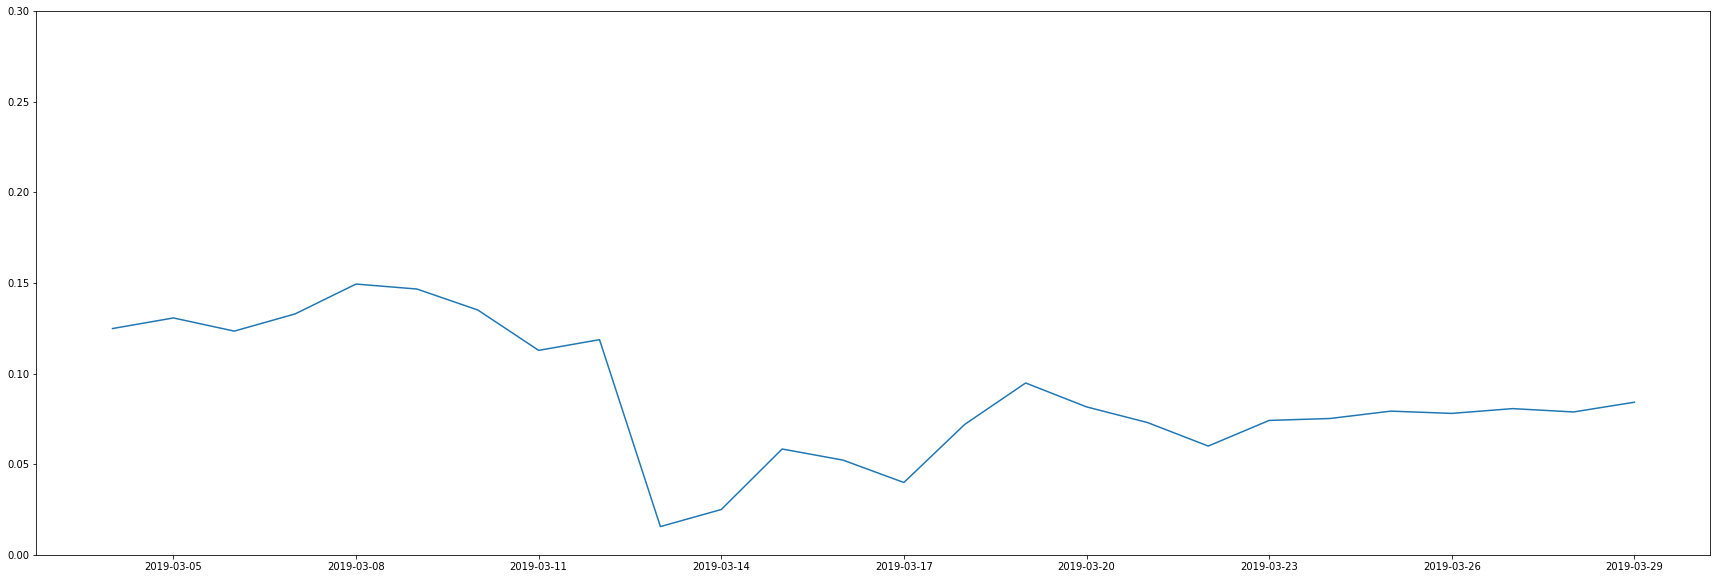

In [40]:
plt.figure(figsize=(30,10))
plt.ylim(0,0.3)
plt.plot(avg_sent_by_day);

We notice that, in general, the attitude manifested in the tweets gathered by us has a neutral-positive bend.

In [41]:
pos_individual_sent_by_day = merged_dataset['pos']
neg_individual_sent_by_day = merged_dataset['neg']
neutral_individual_sent_by_day = merged_dataset['neutral']

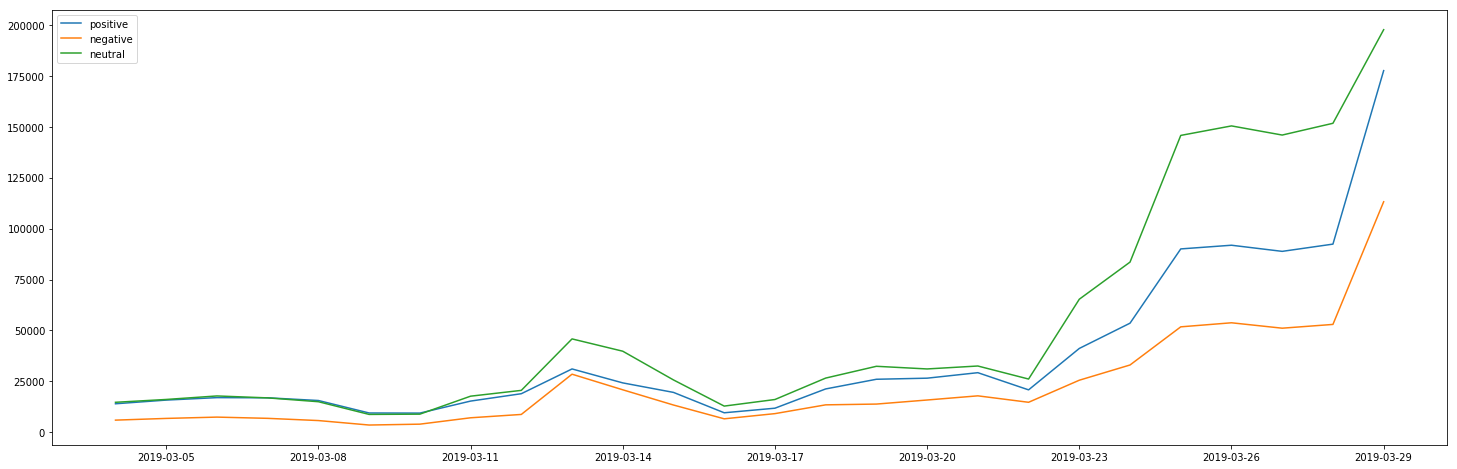

In [42]:
fig, ax = plt.subplots(figsize=(25,8));
ax.plot(pos_individual_sent_by_day, label='positive')
ax.plot(neg_individual_sent_by_day, label='negative');
ax.plot(neutral_individual_sent_by_day, label='neutral');
leg = ax.legend();

It is noticed that there are considerable increase in number of tweets as the month went on. This is because of our data gathering strategy which was split in two different ways. In the latter half of our data gathering process, we had much more flexible approach to compiling tweets, and that is reflected in the above trend clearly.

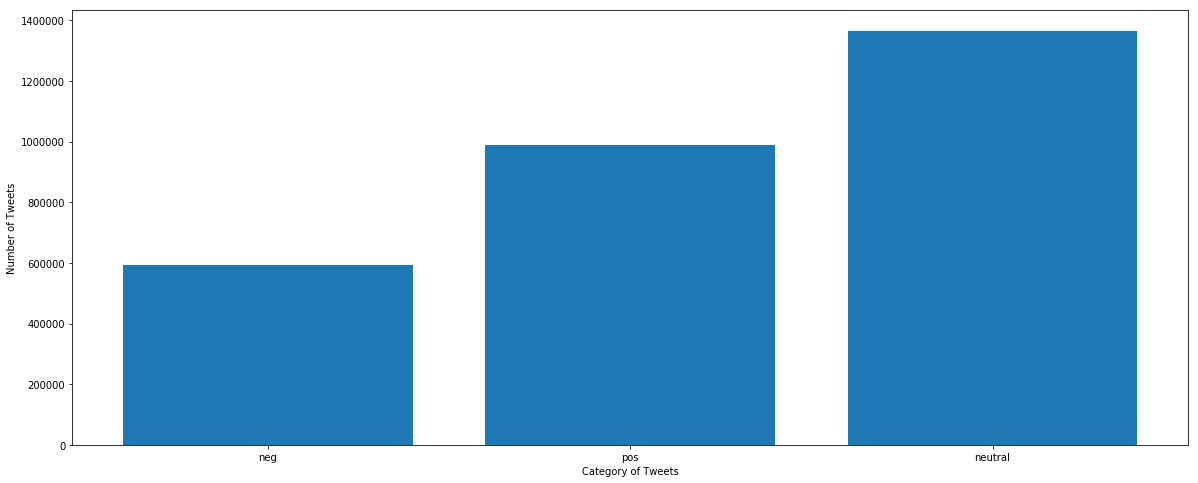

In [43]:
df_for_barplot = merged_dataset[['neg', 'pos', 'neutral']]
df_bar_plot_v = df_for_barplot.sum()

plt.figure(figsize=(20,8))
plt.ylabel('Number of Tweets')
plt.xlabel('Category of Tweets')
plt.bar(list(df_bar_plot_v.index), list(df_bar_plot_v.values));

# 3. Stock Data

## 3.1 Aggregate Stock Data (S&P500 Top 500 and S&P500 top 50)

We downloaded two different forms of datasets for stocks.

1) S&P500 Complete Index

2) S&P500 Top 50 Stocks index (the companies we gathered the tweets for)

In [44]:
# data for complete S&P500 index (gathered for analysis)
agg_sp500 = pd.read_csv('^GSPC.csv')
agg_sp500.set_index('Date', inplace=True)
agg_sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,2485.739990,3702620000
2018-12-31,2498.939941,2509.239990,2482.820068,2506.850098,2506.850098,3442870000
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3733160000
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3822860000
2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4213410000


In [45]:
# S&P500 Top 50 Dataset
# We will use the values from this dataset for our causality analysis
agg_sp50 = pd.read_excel('S&PTop50 Aggregate Data-.xls')
agg_sp50.rename(columns={'Effective date ':'date'}, inplace=True)
agg_sp50.set_index('date', inplace=True)

In [46]:
agg_sp50 = pd.DataFrame(agg_sp50['S&P 500 Top 50'])
agg_sp50.head()

,S&P 500 Top 50
date,
2018-12-31,1999.51
2019-01-02,2008.08
2019-01-03,1947.96
2019-01-04,2019.01
2019-01-07,2029.65


## 3.2 Analyzing Stock Market Behaviour

In [47]:
# dataframe constructed that will eventually be used for causality analysis
df_for_causality = merged_dataset.merge(agg_sp50, left_index=True, right_index=True)

The dataframe captures tweets and their sentiments, along with S&P500 Top 50 Index, from 4th March 2019 to 29th March 2019.

In [48]:
df_for_causality.head()

,neg,neutral,pos,abs_sentiment,rel_sentiment,S&P 500 Top 50
date,,,,,,
2019-03-04,5970,14727,14000,8030,0.402103,2208.68
2019-03-05,6811,16115,15810,8999,0.397816,2210.25
2019-03-06,7452,17841,17015,9563,0.390853,2199.74
2019-03-07,6847,16893,16929,10082,0.424041,2180.94
2019-03-08,5759,15008,15602,9843,0.460793,2177.70


### 3.2.1 With Absolute Closing Price Values

In [49]:
stocks = df_for_causality['S&P 500 Top 50']

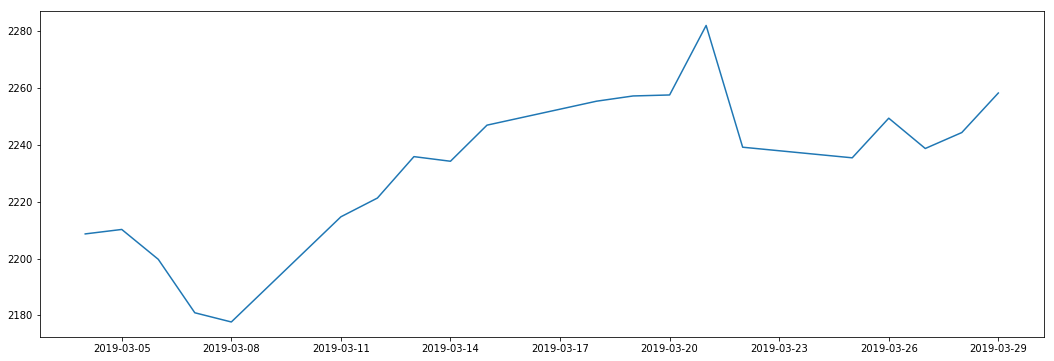

In [50]:
# Plotting stocks behaviour time series
plt.figure(figsize=(18,6))
plt.plot(stocks)
plt.show();

We draw an autocorrelation plot to determine how much does the stock price correlate with its lagged value.

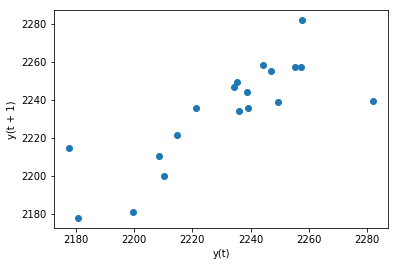

In [51]:
# Creating Autocorrelation plot
from pandas.plotting import lag_plot
lag_plot(stocks)
plt.show();

In [52]:
# getting correlation matrix for lagged values
values = pd.DataFrame(stocks.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.803534
t+1  0.803534  1.000000


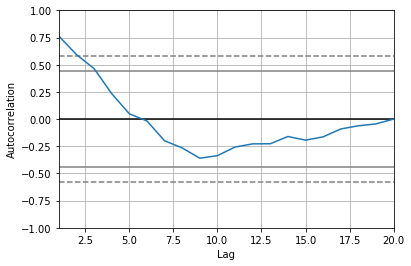

In [53]:
# autocorrelation plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(stocks)
plt.show();

We can clearly see that there is a definite relationship between lagged values of stock price and stock price on certain day.

Further connection is established by an Autoregressive model, which is used for Univariate Time Series.

In [54]:
from statsmodels.tsa.ar_model import AR

# split dataset
X = stocks.values
# train autoregression
model = AR(X)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

model_fit.summary()

Lag: 8
Coefficients: [ 2.19249637e+03  1.05702162e-01 -1.17341363e-01  2.45042828e-01
 -4.22081749e-02 -4.44440521e-02  3.69473989e-01 -4.61602602e-01
 -3.15810014e-02]


### 3.2.2 Using Log-Return values

In finance, it is a common practice to use log-return values of stock price instead of absolute value. We transform our dataset to include log-return values (and corresponding percentage changes, just for comparison)

In [55]:
stocks = pd.DataFrame(stocks)

In [56]:
stocks['pct_change'] = stocks['S&P 500 Top 50'].pct_change()
stocks['log_ret'] = np.log(stocks['S&P 500 Top 50'])\
- np.log(stocks['S&P 500 Top 50'].shift(1))

In [57]:
stocks.fillna(0, inplace=True)

In [58]:
log_return = stocks['log_ret']

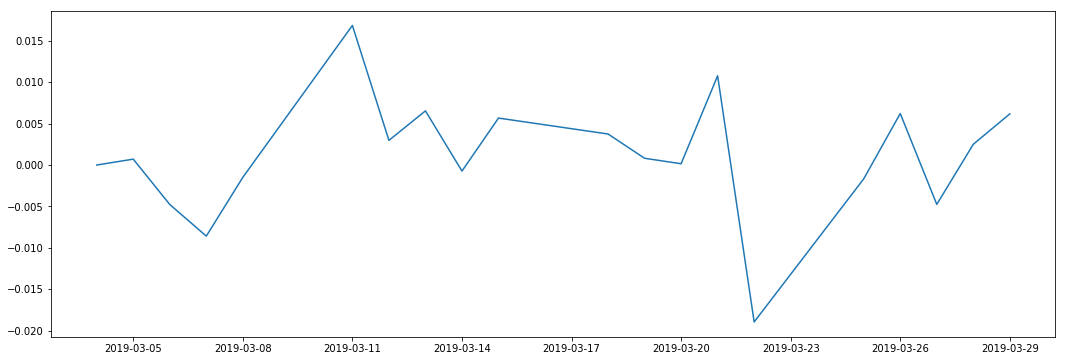

In [59]:
plt.figure(figsize=(18,6))
plt.plot(log_return)
plt.show();

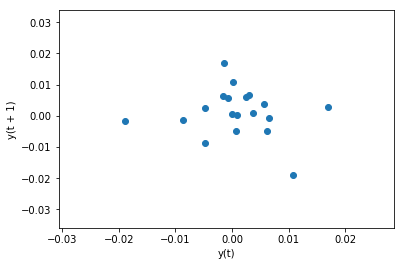

In [60]:
# Creating Autocorrelation plot
from pandas.plotting import lag_plot
lag_plot(log_return)
plt.show();

In [61]:
# getting correlation matrix for lagged values
values = pd.DataFrame(log_return.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000 -0.112558
t+1 -0.112558  1.000000


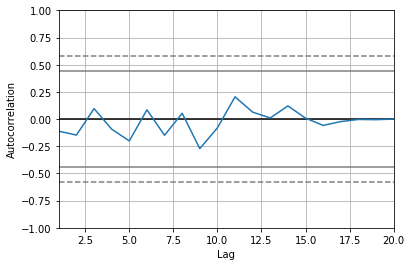

In [62]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(log_return)
plt.show();

In [63]:
from statsmodels.tsa.ar_model import AR
# split dataset
X = log_return.values
# train autoregression
model = AR(X)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

model_fit.summary()

Lag: 8
Coefficients: [ 2.56513270e-04 -3.17672122e-01 -2.52004437e-01  2.82283059e-01
  6.05762046e-02 -4.44729778e-02  2.19733362e-01 -3.98043964e-01
  2.17318146e-01]


# 4. Causality Analysis

In [64]:
df_for_causality['pct_change'] = df_for_causality['S&P 500 Top 50'].pct_change()
df_for_causality['log_ret'] = np.log(df_for_causality['S&P 500 Top 50'])\
- np.log(df_for_causality['S&P 500 Top 50'].shift(1))

In [65]:
df_for_causality.fillna(value=0, inplace=True)

In [66]:
df_for_causality.head()

,neg,neutral,pos,abs_sentiment,rel_sentiment,S&P 500 Top 50,pct_change,log_ret
date,,,,,,,,
2019-03-04,5970,14727,14000,8030,0.402103,2208.68,0.000000,0.000000
2019-03-05,6811,16115,15810,8999,0.397816,2210.25,0.000711,0.000711
2019-03-06,7452,17841,17015,9563,0.390853,2199.74,-0.004755,-0.004766
2019-03-07,6847,16893,16929,10082,0.424041,2180.94,-0.008546,-0.008583
2019-03-08,5759,15008,15602,9843,0.460793,2177.70,-0.001486,-0.001487


### 4.1 Check if time series are stationary

We test if our time series are stationary. For this purpose we utilise the ADF test, applied to a single series at a time (univariate time series). We utilised the python implementation available via statsmodel.

In [67]:
# ADF (Augmented Dickey Fuller) Test
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag=8)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [68]:
adf_test(df_for_causality['S&P 500 Top 50'])

Results of Dickey-Fuller Test:
Test Statistic                -1.485676e+01
p-value                        1.743628e-27
#Lags Used                     8.000000e+00
Number of Observations Used    1.100000e+01
Critical Value (1%)           -4.223238e+00
Critical Value (5%)           -3.189369e+00
Critical Value (10%)          -2.729839e+00
dtype: float64


In [69]:
adf_test(df_for_causality['log_ret'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.020101
p-value                         0.033059
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


From the above tests, we see that the time series for absolute and log returns are stationary. Log return values are significant at the 5% level. It suffices for our case, since we do not have a lot of data to play around with, and results are bound to be weak.

In [73]:
adf_test(df_for_causality['rel_sentiment'])

Results of Dickey-Fuller Test:
Test Statistic                -7.321378e+00
p-value                        1.191696e-10
#Lags Used                     8.000000e+00
Number of Observations Used    1.100000e+01
Critical Value (1%)           -4.223238e+00
Critical Value (5%)           -3.189369e+00
Critical Value (10%)          -2.729839e+00
dtype: float64


In [74]:
adf_test(df_for_causality['abs_sentiment'])

Results of Dickey-Fuller Test:
Test Statistic                  2.155435
p-value                         0.998844
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


The relative and absolute sentiment ADFuller tests show that relative sentiment is stationary, but absolute sentiment is not.

In [75]:
adf_test(df_for_causality['pos'])

Results of Dickey-Fuller Test:
Test Statistic                  1.599812
p-value                         0.997857
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


In [76]:
adf_test(df_for_causality['neg'])

Results of Dickey-Fuller Test:
Test Statistic                  2.598365
p-value                         0.999075
#Lags Used                      7.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


The numbers of positive and negative tweets are not stationary. We log transform the positive and negative tweets columns in order to make them stationary.

In [70]:
df_for_causality['log_pos'] = np.log(df_for_causality['pos'])\
- np.log(df_for_causality['pos'].shift(1))
df_for_causality['log_neg'] = np.log(df_for_causality['neg'])\
- np.log(df_for_causality['neg'].shift(1))

In [71]:
df_for_causality.fillna(0, inplace=True)

In [72]:
adf_test(df_for_causality['log_pos'])

Results of Dickey-Fuller Test:
Test Statistic                 -0.518347
p-value                         0.888386
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


In [77]:
adf_test(df_for_causality['log_neg'])

Results of Dickey-Fuller Test:
Test Statistic                  0.138594
p-value                         0.968599
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


The results have improved, but still we do not have complete stationarity. We will have to continue with current values, since we do not have a lot of data to play around with.

### 4.2 Granger-Causality of Stock Price with different variables

We utilise Python's built-in implementation of granger causality to determine if the stock price is causally affected by different variables. We will go one by one through all the variables, with different lags. Since we have barely a month of day (less than 30 trading days), we will utilise 6 lag days.

In [78]:
from statsmodels.tsa.stattools import grangercausalitytests

#### 4.2.1 Absolute Stock Price and Sentiment Variables

In [79]:
granger_test_result = grangercausalitytests(
    df_for_causality[['S&P 500 Top 50','rel_sentiment']].values,maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4033  , p=0.5344  , df_denom=16, df_num=1
ssr based chi2 test:   chi2=0.4789  , p=0.4889  , df=1
likelihood ratio test: chi2=0.4729  , p=0.4916  , df=1
parameter F test:         F=0.4033  , p=0.5344  , df_denom=16, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6422  , p=0.5420  , df_denom=13, df_num=2
ssr based chi2 test:   chi2=1.7784  , p=0.4110  , df=2
likelihood ratio test: chi2=1.6959  , p=0.4283  , df=2
parameter F test:         F=0.6422  , p=0.5420  , df_denom=13, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3601  , p=0.7832  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=1.8365  , p=0.6070  , df=3
likelihood ratio test: chi2=1.7439  , p=0.6272  , df=3
parameter F test:         F=0.3601  , p=0.7832  , df_denom=10, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2694  , p=0.8887  , df_d

In [80]:
granger_test_result = grangercausalitytests(
    df_for_causality[['S&P 500 Top 50','abs_sentiment']].values,maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3661  , p=0.5536  , df_denom=16, df_num=1
ssr based chi2 test:   chi2=0.4347  , p=0.5097  , df=1
likelihood ratio test: chi2=0.4298  , p=0.5121  , df=1
parameter F test:         F=0.3661  , p=0.5536  , df_denom=16, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2551  , p=0.7786  , df_denom=13, df_num=2
ssr based chi2 test:   chi2=0.7064  , p=0.7025  , df=2
likelihood ratio test: chi2=0.6929  , p=0.7072  , df=2
parameter F test:         F=0.2551  , p=0.7786  , df_denom=13, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2000  , p=0.8941  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=1.0198  , p=0.7965  , df=3
likelihood ratio test: chi2=0.9903  , p=0.8036  , df=3
parameter F test:         F=0.2000  , p=0.8941  , df_denom=10, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1197  , p=0.9711  , df_d

In [81]:
granger_test_result = grangercausalitytests(
    df_for_causality[['S&P 500 Top 50','pos']].values,maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5247  , p=0.4793  , df_denom=16, df_num=1
ssr based chi2 test:   chi2=0.6231  , p=0.4299  , df=1
likelihood ratio test: chi2=0.6131  , p=0.4336  , df=1
parameter F test:         F=0.5247  , p=0.4793  , df_denom=16, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2135  , p=0.8105  , df_denom=13, df_num=2
ssr based chi2 test:   chi2=0.5914  , p=0.7440  , df=2
likelihood ratio test: chi2=0.5818  , p=0.7476  , df=2
parameter F test:         F=0.2135  , p=0.8105  , df_denom=13, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2665  , p=0.8481  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=1.3591  , p=0.7151  , df=3
likelihood ratio test: chi2=1.3075  , p=0.7274  , df=3
parameter F test:         F=0.2665  , p=0.8481  , df_denom=10, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1074  , p=0.9761  , df_d

In [82]:
granger_test_result = grangercausalitytests(
    df_for_causality[['S&P 500 Top 50','neg']].values,maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6180  , p=0.4433  , df_denom=16, df_num=1
ssr based chi2 test:   chi2=0.7339  , p=0.3916  , df=1
likelihood ratio test: chi2=0.7200  , p=0.3961  , df=1
parameter F test:         F=0.6180  , p=0.4433  , df_denom=16, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2247  , p=0.8018  , df_denom=13, df_num=2
ssr based chi2 test:   chi2=0.6222  , p=0.7326  , df=2
likelihood ratio test: chi2=0.6117  , p=0.7365  , df=2
parameter F test:         F=0.2247  , p=0.8018  , df_denom=13, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3022  , p=0.8232  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=1.5413  , p=0.6728  , df=3
likelihood ratio test: chi2=1.4754  , p=0.6880  , df=3
parameter F test:         F=0.3022  , p=0.8232  , df_denom=10, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1428  , p=0.9606  , df_d

The Granger-Causality F-test shows that we can not conclude absolute stock price is caused by absolute or relative sentiment, as well as number of positive and negative tweets, for any lag number.

#### 4.2.2 Log-Return Stock Price and Sentiment Variables

In [83]:
granger_test_result = grangercausalitytests(
    df_for_causality[['log_ret','rel_sentiment']].values,maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1058  , p=0.7492  , df_denom=16, df_num=1
ssr based chi2 test:   chi2=0.1256  , p=0.7230  , df=1
likelihood ratio test: chi2=0.1252  , p=0.7235  , df=1
parameter F test:         F=0.1058  , p=0.7492  , df_denom=16, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0541  , p=0.9475  , df_denom=13, df_num=2
ssr based chi2 test:   chi2=0.1499  , p=0.9278  , df=2
likelihood ratio test: chi2=0.1493  , p=0.9281  , df=2
parameter F test:         F=0.0541  , p=0.9475  , df_denom=13, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1180  , p=0.9475  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=0.6017  , p=0.8960  , df=3
likelihood ratio test: chi2=0.5913  , p=0.8984  , df=3
parameter F test:         F=0.1180  , p=0.9475  , df_denom=10, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2841  , p=0.8794  , df_d

In [84]:
granger_test_result = grangercausalitytests(
    df_for_causality[['log_ret','abs_sentiment']].values,maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0877  , p=0.7710  , df_denom=16, df_num=1
ssr based chi2 test:   chi2=0.1041  , p=0.7470  , df=1
likelihood ratio test: chi2=0.1038  , p=0.7473  , df=1
parameter F test:         F=0.0877  , p=0.7710  , df_denom=16, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0338  , p=0.9669  , df_denom=13, df_num=2
ssr based chi2 test:   chi2=0.0935  , p=0.9543  , df=2
likelihood ratio test: chi2=0.0933  , p=0.9544  , df=2
parameter F test:         F=0.0338  , p=0.9669  , df_denom=13, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1321  , p=0.9388  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=0.6735  , p=0.8794  , df=3
likelihood ratio test: chi2=0.6605  , p=0.8824  , df=3
parameter F test:         F=0.1321  , p=0.9388  , df_denom=10, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1469  , p=0.9586  , df_d

In [85]:
granger_test_result = grangercausalitytests(
    df_for_causality[['log_ret','pos']].values,maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0550  , p=0.8175  , df_denom=16, df_num=1
ssr based chi2 test:   chi2=0.0653  , p=0.7983  , df=1
likelihood ratio test: chi2=0.0652  , p=0.7984  , df=1
parameter F test:         F=0.0550  , p=0.8175  , df_denom=16, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0005  , p=0.9995  , df_denom=13, df_num=2
ssr based chi2 test:   chi2=0.0015  , p=0.9993  , df=2
likelihood ratio test: chi2=0.0015  , p=0.9993  , df=2
parameter F test:         F=0.0005  , p=0.9995  , df_denom=13, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1492  , p=0.9279  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=0.7608  , p=0.8588  , df=3
likelihood ratio test: chi2=0.7443  , p=0.8627  , df=3
parameter F test:         F=0.1492  , p=0.9279  , df_denom=10, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0964  , p=0.9804  , df_d

In [86]:
granger_test_result = grangercausalitytests(
    df_for_causality[['log_ret','neg']].values,maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0322  , p=0.8599  , df_denom=16, df_num=1
ssr based chi2 test:   chi2=0.0382  , p=0.8451  , df=1
likelihood ratio test: chi2=0.0381  , p=0.8451  , df=1
parameter F test:         F=0.0322  , p=0.8599  , df_denom=16, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0115  , p=0.9885  , df_denom=13, df_num=2
ssr based chi2 test:   chi2=0.0320  , p=0.9841  , df=2
likelihood ratio test: chi2=0.0319  , p=0.9842  , df=2
parameter F test:         F=0.0115  , p=0.9885  , df_denom=13, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1082  , p=0.9533  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=0.5520  , p=0.9073  , df=3
likelihood ratio test: chi2=0.5432  , p=0.9093  , df=3
parameter F test:         F=0.1082  , p=0.9533  , df_denom=10, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0792  , p=0.9863  , df_d

Similar to absolute stock price case, we cannot reject the null hypothesis that log return of stock prices is not granger-caused by sentiment variables.

### 4.3 Vector Autoregressive (VAR) model for Multivariate Timeseries

A Vector Autoregressive model is used to determine linear regression equation for multivariate time series, depending on number of lag days.

#### 4.3.1 Model with Log-Return

In [95]:
var_model = df_for_causality[['log_ret', 'rel_sentiment', 'log_pos', 'log_neg', 'pos', 'neg']]

In [96]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults

model = VAR(endog=var_model, freq='B')
model_fit = model.fit(2)

In [97]:
model_fit.test_causality('log_ret', ['rel_sentiment', 'log_pos', 'log_neg', 'pos', 'neg'], kind='f').summary()

Test statistic,Critical value,p-value,df
0.5569,2.165,0.835,"(10, 30)"


In [98]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 06, Apr, 2019
Time:                     08:39:08
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -19.9671
Nobs:                     18.0000    HQIC:                  -23.2933
Log likelihood:           139.183    FPE:                4.39790e-10
AIC:                     -23.8254    Det(Omega_mle):     1.07875e-11
--------------------------------------------------------------------
Results for equation log_ret
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.079181         0.049788           -1.590           0.112
L1.log_ret               1.000134         0.754599            1.325           0.185
L1.rel_sentiment        -5.497024         3.80

We see that log return is not statistically significant with any of our chosen variables. However, their predict power cannot be ruled out.

#### 4.3.2 Model with Absolute Stock Price

In [99]:
var_model = df_for_causality[['S&P 500 Top 50', 'rel_sentiment', 'log_pos', 'log_neg', 'pos']]

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults

model = VAR(endog=var_model, freq='B')
model_fit = model.fit(2)

In [100]:
model_fit.test_causality('S&P 500 Top 50', ['rel_sentiment', 'log_pos', 'log_neg', 'pos'], kind='f').summary()

Test statistic,Critical value,p-value,df
0.2321,2.217,0.982,"(8, 35)"


In [101]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 06, Apr, 2019
Time:                     08:39:32
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    11.7037
Nobs:                     18.0000    HQIC:                   9.35823
Log likelihood:          -153.552    FPE:                    21566.9
AIC:                      8.98310    Det(Omega_mle):         1986.83
--------------------------------------------------------------------
Results for equation S&P 500 Top 50
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                  1041.643399       843.627892            1.235           0.217
L1.S&P 500 Top 50         0.772325         0.560885            1.377           0.169
L1.rel_sentiment       -621.480092 

Significance could not be established.

# 5. Individual Stock Data (S&P500 Top 50)

In [ ]:
len(df['ticker'].unique())

In [ ]:
tickers = list(set(df['ticker'].unique()))

In [ ]:
tickers.append('BRK-B')
tickers.remove('BRK')

In [ ]:
len(tickers)

In [ ]:
# import fix_yahoo_finance as yf

# complete_panel_data = yf.download(tickers, start="2019-03-01", end="2019-03-27")

In [ ]:
import pandas_datareader

start_date = '2019-03-01'
end_date = '2019-03-28'

complete_panel_data = pandas_datareader.get_data_yahoo(tickers, start_date, end_date)

In [ ]:
complete_panel_data.head()

In [ ]:
complete_panel_data.loc[complete_panel_data.index]['Adj Close']

In [ ]:
#complete_panel_data.to_csv('panel_data')